In [16]:
"""
CS 281. Homework 1. Fairness in the Wild
Correspondence to: khkim@cs.stanford.edu
"""
import json
from typing import Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV


## Load the COMPAS Dataset
raw_data = pd.read_csv('./compas-scores-two-years.csv')
print('Num rows: %d' % len(raw_data))

Num rows: 7214


In [17]:
######## Q1. Data pre-processing ########
## TODO: filter out corrupted rows from raw_data and store in a variable name "df"
## df should be a pandas.DataFrame object

def pre_process_compas_data(raw_data):
    # only keep rows with charge date within 30days of arrest
    df = raw_data[raw_data.days_b_screening_arrest.notnull()]
    df = df[np.abs(df.days_b_screening_arrest)<=30]

    # discard rows with recidivist flag == -1
    df = df[df.is_recid != -1]

    # remove rows with c_charge_degree == 0
    df = df[df.c_charge_degree != 0]

    # remove rows with no proper score_text
    df = df[df.score_text != 'N/A']

    print('Q1: Num data points after filtering: %d' % len(df))
    return df

In [18]:
df = pre_process_compas_data(raw_data)

Q1: Num data points after filtering: 6172


In [19]:
######## Q2. Data Visualization ########
## TODO: Visualize decile_scores as a histogram for different races, genders.

def visualize_decile_score_histograms(df):
    print('Q2: Data Visualization')

    axarr_sex = df.hist(column='decile_score', by='sex', rwidth=0.9, sharey=False, 
                    align='mid', figsize=(10,5))

    for ax in axarr_sex.flatten():
        ax.set_xlabel("decile_score")
        ax.set_ylabel("count")
        ax.set_xticks(np.arange(1,11))

    axarr_race = df[df.race.isin(['Caucasian','Hispanic','African-American'])].hist(column='decile_score', by='race', 
                                                                                rwidth=0.9, sharey=True, 
                                                                                layout=(1,3),
                                                                                align='mid', figsize=(20,5))
    for ax in axarr_race.flatten():
        ax.set_xlabel("decile_score")
        ax.set_ylabel("count")
        ax.set_xticks(np.arange(1,11))
        
    axarr_race = df[df.race.isin(['Asian','Native American','Other'])].hist(column='decile_score', by='race', 
                                                                                rwidth=0.9, sharey=True, 
                                                                                layout=(1,3),
                                                                                align='mid', figsize=(20,5))
                                                                                
    for ax in axarr_race.flatten():
        ax.set_xlabel("decile_score")
        ax.set_ylabel("count")
        ax.set_xticks(np.arange(1,11))

Q2: Data Visualization


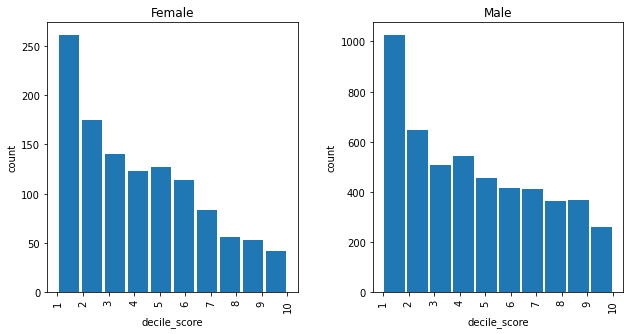

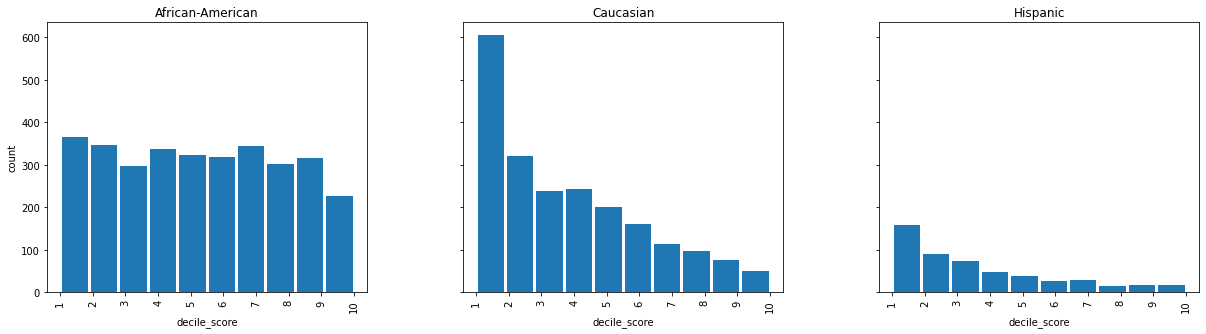

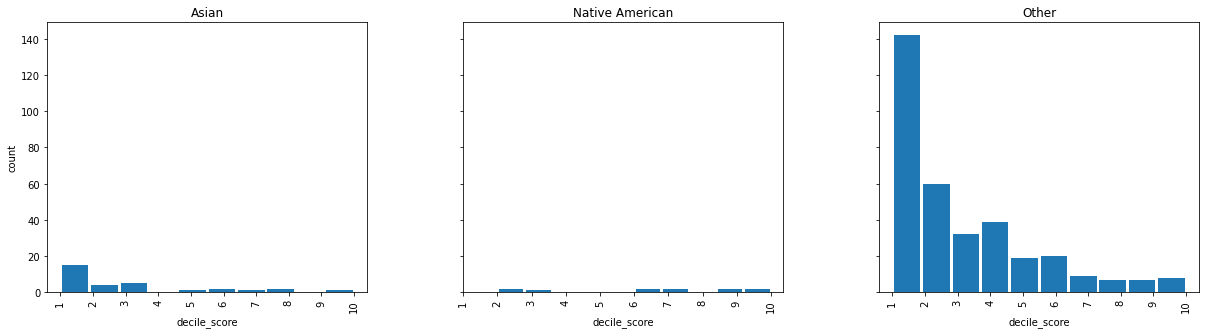

In [20]:
visualize_decile_score_histograms(df)

In [21]:
######## Q3. Learning a Predictor #########
## Do not remove this random seed as it will change the results
np.random.seed(0)

def get_features_target_vectors(df):
    ## (a). Process subset of features in df into one-hot vectors. Store result in features

    target = df.two_year_recid

    x_race = pd.get_dummies(df.race)

    x_sex = pd.get_dummies(df.sex)

    x_age_cat = pd.get_dummies(df.age_cat)

    x_c_charge_degree = pd.get_dummies(df.c_charge_degree)

    x_priors_count = df.priors_count

    features = pd.concat((x_race, x_sex, x_age_cat, x_c_charge_degree, x_priors_count), axis=1)

    return features, target

In [22]:
## (a). Process subset of features in df into one-hot vectors. Store result in features

features, target = get_features_target_vectors(df)

## (b). Split (features, target) into 75% training set, 25% test set

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, target, train_size=0.75)

In [23]:
## (c). Fit a logistic regression model on training set.
print('Q3: Logistic Regression Predictor')

logistic_clf = LogisticRegression(solver='lbfgs', max_iter=10000).fit(X_train, y_train)

print('Train set acc: {:.3f}'.format(logistic_clf.score(X_train, y_train)))
print('Test set acc: {:.3f}'.format(logistic_clf.score(X_test, y_test)))

Q3: Logistic Regression Predictor
Train set acc: 0.677
Test set acc: 0.655


In [24]:
######## Q4: Compute demographic parity ########
def compute_ratio_positive_decisions(clf, X_test, protected_feature=None, thresh=0.5):

    if protected_feature:
        Xp = X_test[X_test[protected_feature]==1]
    else:
        Xp = X_test

    y_pred = clf.predict_proba(Xp)

    f_theta = [p[1] for p in y_pred]

    d = [1 if f >= thresh else 0 for f in f_theta]

    return np.sum(d)/len(d)


    
def evaluate_demographic_parity(clf, X_test):
    print('Demographic Parity\n')

    base_ratio = compute_ratio_positive_decisions(clf, X_test, protected_feature=None, thresh=0.5)
    print('Base ratio: {:.2f}'.format(base_ratio))

    for xp in ['African-American', 'Caucasian', 'Male', 'Female']:
        xp_ratio = compute_ratio_positive_decisions(clf, X_test, protected_feature = xp)
        print('{} ratio: {:.2f}'.format(xp,xp_ratio))

print('Q4: Logistic regression')
evaluate_demographic_parity(logistic_clf, X_test)

Q4: Logistic regression
Demographic Parity

Base ratio: 0.38
African-American ratio: 0.49
Caucasian ratio: 0.29
Male ratio: 0.44
Female ratio: 0.11


In [25]:
######## Q6: Calibration Fairness ########

def discretize_score(v):
    for n in np.arange(5):
        if 0.2*n <= v and v <=0.2*(n+1):
            return n 


def compute_ratio_positives_given_score(clf, score, X_test, y_test, protected_feature=None, thresh=0.5):

    if protected_feature:
        Xp = X_test[X_test[protected_feature]==1]
    else:
        Xp = X_test

    y_pred = clf.predict_proba(Xp)
    f_theta = [p[1] for p in y_pred]

    s = np.array([discretize_score(f) for f in f_theta])
    y_test = np.array(y_test)
    
    z = y_test[np.where(s==score)]
    print('score',score,len(z))

    return np.sum(z)/len(z)


def evaluate_calibration_fairness(clf, X_test, y_test):
    print('Calibration Fairness\n')
    for score in np.arange(5):

        s_ratio = compute_ratio_positives_given_score(clf, score, X_test, y_test, protected_feature=None, thresh=0.5)
        print('Pr(Y=1|s(X)={:}) = {:.2f}'.format(score, s_ratio))
        
        s_protected = []

        for xp in ['African-American', 'Caucasian', 'Male', 'Female']:
            s_ratio = compute_ratio_positives_given_score(clf, score, X_test, y_test, protected_feature=xp, thresh=0.5)
            print('Pr(Y=1|s(X)={:}, {}) = {:.2f}'.format(score, xp ,s_ratio))
            
            s_protected.append(s_ratio)
        print('Std dev over the 4 protected attributes for s(X)={:}: {:.2f}'.format(score, np.std(s_protected)))
        print()


print('Q6: Logistic regression')
evaluate_calibration_fairness(logistic_clf, X_test, y_test)

Q6: Logistic regression
Calibration Fairness

score 0 88
Pr(Y=1|s(X)=0) = 0.20
score 0 21
Pr(Y=1|s(X)=0, African-American) = 0.52
score 0 43
Pr(Y=1|s(X)=0, Caucasian) = 0.47
score 0 49
Pr(Y=1|s(X)=0, Male) = 0.43
score 0 39
Pr(Y=1|s(X)=0, Female) = 0.38
Std dev over the 4 protected attributes for s(X)=0: 0.05

score 1 576
Pr(Y=1|s(X)=1) = 0.28
score 1 231
Pr(Y=1|s(X)=1, African-American) = 0.42
score 1 229
Pr(Y=1|s(X)=1, Caucasian) = 0.48
score 1 415
Pr(Y=1|s(X)=1, Male) = 0.46
score 1 161
Pr(Y=1|s(X)=1, Female) = 0.49
Std dev over the 4 protected attributes for s(X)=1: 0.03

score 2 573
Pr(Y=1|s(X)=2) = 0.50
score 2 331
Pr(Y=1|s(X)=2, African-American) = 0.45
score 2 173
Pr(Y=1|s(X)=2, Caucasian) = 0.46
score 2 509
Pr(Y=1|s(X)=2, Male) = 0.44
score 2 64
Pr(Y=1|s(X)=2, Female) = 0.41
Std dev over the 4 protected attributes for s(X)=2: 0.02

score 3 213
Pr(Y=1|s(X)=3) = 0.68
score 3 152
Pr(Y=1|s(X)=3, African-American) = 0.52
score 3 49
Pr(Y=1|s(X)=3, Caucasian) = 0.41
score 3 200
Pr(Y=

In [28]:
######## Q7: Post-hoc Calibration Fairness ########

logistic_clf = LogisticRegression(solver='lbfgs', max_iter=10000) #.fit(X_train, y_train)

calibrated_clf = CalibratedClassifierCV(base_estimator=logistic_clf, cv=3).fit(X_train, y_train)

print('Q7: Post-hoc calibration')
evaluate_calibration_fairness(calibrated_clf, X_test, y_test)

Q7: Post-hoc calibration
Calibration Fairness

score 0 71
Pr(Y=1|s(X)=0) = 0.17
score 0 7
Pr(Y=1|s(X)=0, African-American) = 0.43
score 0 42
Pr(Y=1|s(X)=0, Caucasian) = 0.48
score 0 38
Pr(Y=1|s(X)=0, Male) = 0.39
score 0 33
Pr(Y=1|s(X)=0, Female) = 0.42
Std dev over the 4 protected attributes for s(X)=0: 0.03

score 1 592
Pr(Y=1|s(X)=1) = 0.28
score 1 245
Pr(Y=1|s(X)=1, African-American) = 0.43
score 1 230
Pr(Y=1|s(X)=1, Caucasian) = 0.48
score 1 425
Pr(Y=1|s(X)=1, Male) = 0.46
score 1 167
Pr(Y=1|s(X)=1, Female) = 0.48
Std dev over the 4 protected attributes for s(X)=1: 0.02

score 2 574
Pr(Y=1|s(X)=2) = 0.51
score 2 331
Pr(Y=1|s(X)=2, African-American) = 0.45
score 2 173
Pr(Y=1|s(X)=2, Caucasian) = 0.46
score 2 510
Pr(Y=1|s(X)=2, Male) = 0.44
score 2 64
Pr(Y=1|s(X)=2, Female) = 0.41
Std dev over the 4 protected attributes for s(X)=2: 0.02

score 3 213
Pr(Y=1|s(X)=3) = 0.68
score 3 152
Pr(Y=1|s(X)=3, African-American) = 0.52
score 3 49
Pr(Y=1|s(X)=3, Caucasian) = 0.41
score 3 200
Pr(Y=

In [27]:
######## Q8: Calibration effect on Demographic Parity ########

print('Q8: Post-hoc calibration')
evaluate_demographic_parity(calibrated_clf, X_test)

Q8: Post-hoc calibration
Demographic Parity

Base ratio: 0.38
African-American ratio: 0.49
Caucasian ratio: 0.29
Male ratio: 0.44
Female ratio: 0.11
